In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Meanshift

Mục tiêu của thuật toán meanshift là đi tìm cực đại địa phương từ một vị trí bắt đầu gần đó trong không gian hàm mật độ xác suất nào đó. Cụ thể hơn khi đặt trong bài toán tracking trong video, tại frame ảnh thứ $t$, vật thể được xác định là nằm trong cửa sổ ảnh $W^{(t)}$, mục tiêu là tại frame thứ $t+1$, xác định một hàm mật độ xác suất chỉ khả năng một vị trí pixel nằm trong vật thể, khi đó nhiệm vụ của thuật toán mean-shift là dịch cửa số $W^{(t)}$ tới vị trí có khả năng là vật thể cao nhất. 

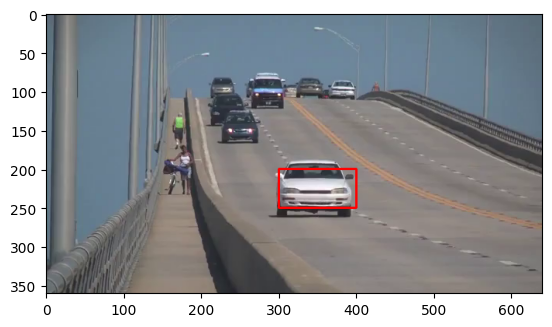

In [2]:
cap = cv.VideoCapture("../images/slow_traffic_small.mp4") # đọc video
ret, frame = cap.read() # đọc frame đầu tiên của video

# khởi tạo vị trí cửa sổ theo dõi vật thể ban đầu
x, y, w, h = 300, 200, 100, 50
track_window = (x, y, w, h)

img_track = cv.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

plt.imshow(cv.cvtColor(img_track, cv.COLOR_BGR2RGB))

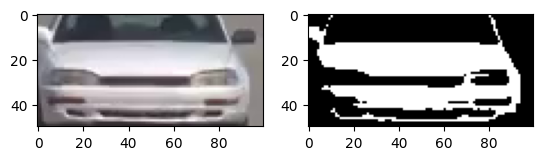

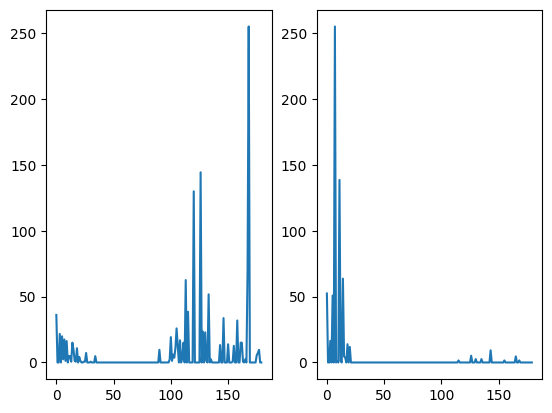

In [3]:
cap = cv.VideoCapture("../images/slow_traffic_small.mp4") # đọc video
ret, frame = cap.read() # đọc frame đầu tiên của video

# khởi tạo vị trí cửa sổ theo dõi vật thể ban đầu
x, y, w, h = 300, 200, 100, 50
track_window = (x, y, w, h)

roi = frame[y:y+h, x:x+w]
roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV) # chuyển không gian màu BGR sang HSV
roi_mask = cv.inRange(roi_hsv, np.array((0., 0.,170.)), np.array((180.,255.,255.)))
roi_hist= cv.calcHist([roi_hsv], [0], roi_mask, [180], [0, 180]) # thống kê histogram giá trị Hue (màu sắc) trong cửa sổ theo dõi
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)

plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(roi, cv.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(roi_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

# một cửa sổ ảnh ngẫu nhiên khác không chứa vật thể
roi2 = frame[150:150+h, 450:450+w]
roi2_hsv = cv.cvtColor(roi2, cv.COLOR_BGR2HSV) # chuyển không gian màu BGR sang HSV
roi2_hist= cv.calcHist([roi2_hsv], [0], None, [180], [0, 180]) # thống kê histogram giá trị Hue (màu sắc) trong cửa sổ theo dõi
cv.normalize(roi2_hist, roi2_hist, 0, 255, cv.NORM_MINMAX)

plt.subplot(1, 2, 1)
plt.plot(roi_hist)
plt.subplot(1, 2, 2)
plt.plot(roi2_hist)
plt.show()

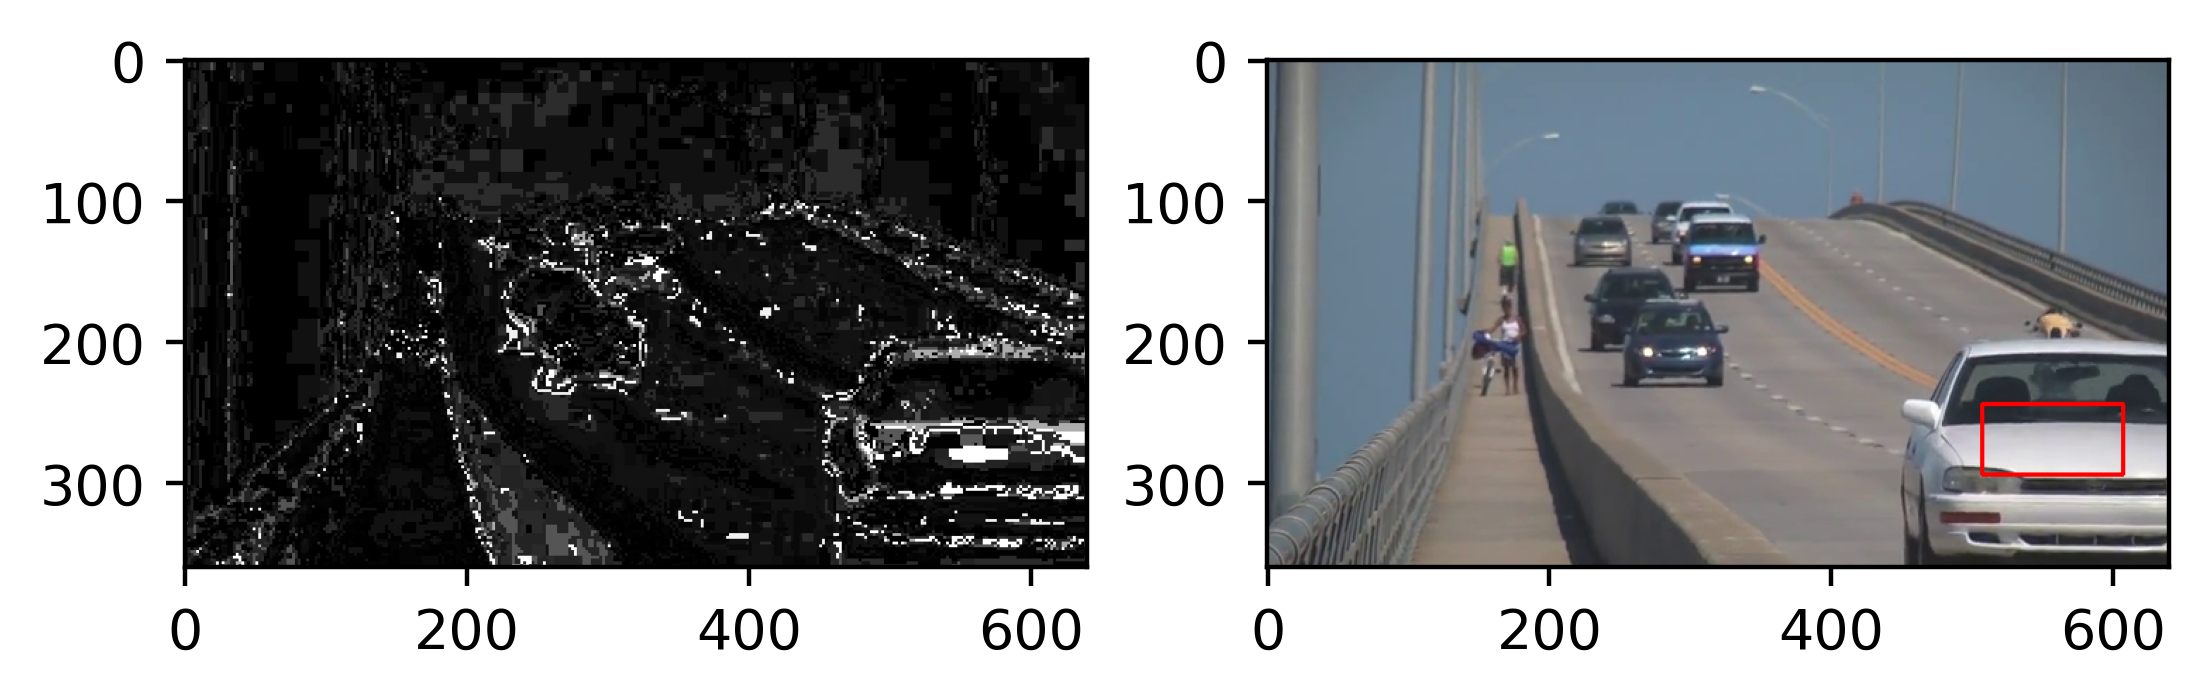

In [4]:
cap = cv.VideoCapture("../images/slow_traffic_small.mp4") # đọc video
ret, frame = cap.read() # đọc frame đầu tiên của video

# khởi tạo vị trí cửa sổ theo dõi vật thể ban đầu
x, y, w, h = 300, 200, 100, 50
track_window = (x, y, w, h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]
roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV) # chuyển không gian màu BGR sang HSV
roi_mask = cv.inRange(roi_hsv, np.array((0., 0.,200.)), np.array((180.,255.,255.)))
roi_hist= cv.calcHist([roi_hsv], [0], roi_mask, [180], [0, 180]) # thống kê histogram giá trị Hue (màu sắc) trong cửa sổ theo dõi
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)

# đặt điều kiện dừng cho mean-shift, sau 10 lần lặp hoặc chỉ dịch đi 1 đơn vị pixel
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )

count_frame = 0

plt.rcParams['figure.dpi'] = 400

while True:
    # duyệt các frame tiếp theo
    ret, frame = cap.read()
    count_frame += 1

    frame_hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # xác định xác suất khả năng vị trí mới của cửa sổ theo dõi dựa trên histogram của kênh màu Hue
    prob = cv.calcBackProject([frame_hsv], [0], roi_hist, [0, 180], 1)

    ret, track_window = cv.meanShift(prob, track_window, term_crit)

    x, y, w, h = track_window
    img2 = cv.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)

    if count_frame % 5 == 0:
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.imshow(prob, cmap='gray', vmin=0, vmax=255)
        plt.subplot(1, 2, 2)
        plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
        plt.show()
               
    if count_frame == 150: 
        break